<a href="https://colab.research.google.com/github/yilmajung/belief_and_llms_v0/blob/main/3_investigate_correlations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phase 3: Investigate Demographic Vector Correlations

**Goal:** Investigate how steering with one demographic vector affects other demographic representations.

**Key Design:** Extract and steer at the **SAME layer**. For each layer (5-20):
- Load vectors extracted at that layer
- Steer at that same layer
- Measure effects on other demographics

**Key Questions:**
1. When we inject a "Republican" steering vector, how do other demographic similarities change?
2. Are there clusters of demographics that move together?
3. Which layer produces the cleanest/strongest steering effects?

In [1]:
!pip install -q -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 33.3 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
# Link to Google Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
# Configuration
BASE_DIR = "/content/drive/MyDrive/belief_and_llms_v0"
VECTOR_DIR = os.path.join(BASE_DIR, "vectors")
LAYERS = list(range(5, 21))  # Layers 5-20

# Load all layer vectors
all_layer_vectors = {}
for layer in LAYERS:
    path = os.path.join(VECTOR_DIR, f"gss_demographic_vectors_layer{layer}.pt")
    if os.path.exists(path):
        all_layer_vectors[layer] = torch.load(path)
        print(f"Loaded Layer {layer}: {len(all_layer_vectors[layer])} vectors")
    else:
        print(f"WARNING: Layer {layer} vectors not found at {path}")

print(f"\nLoaded vectors for {len(all_layer_vectors)} layers.")

Loaded Layer 5: 34 vectors
Loaded Layer 6: 34 vectors
Loaded Layer 7: 34 vectors
Loaded Layer 8: 34 vectors
Loaded Layer 9: 34 vectors
Loaded Layer 10: 34 vectors
Loaded Layer 11: 34 vectors
Loaded Layer 12: 34 vectors
Loaded Layer 13: 34 vectors
Loaded Layer 14: 34 vectors
Loaded Layer 15: 34 vectors
Loaded Layer 16: 34 vectors
Loaded Layer 17: 34 vectors
Loaded Layer 18: 34 vectors
Loaded Layer 19: 34 vectors
Loaded Layer 20: 34 vectors

Loaded vectors for 16 layers.


## 0. Analyze Layer-wise Magnitude and Delta

Due to residual connections, magnitude accumulates across layers. To find the "sweet spot" for steering, we should analyze:
1. **Absolute magnitude** - Total accumulated signal at each layer
2. **Delta magnitude (Δ)** - How much each layer *contributes* (layer N vs layer N-1)

The layer with the highest Δ is where the model adds the most demographic-specific information.

In [5]:
# Compute magnitude statistics for each layer
magnitude_by_layer = {}
magnitude_by_demo = {}  # For tracking individual demographics across layers

for layer in sorted(all_layer_vectors.keys()):
    vectors = all_layer_vectors[layer]
    magnitudes = []

    for label, data in vectors.items():
        mag = data['magnitude']
        magnitudes.append(mag)

        # Track each demographic across layers
        if label not in magnitude_by_demo:
            magnitude_by_demo[label] = {}
        magnitude_by_demo[label][layer] = mag

    magnitude_by_layer[layer] = {
        'mean': np.mean(magnitudes),
        'min': np.min(magnitudes),
        'max': np.max(magnitudes),
        'std': np.std(magnitudes),
        'range': np.max(magnitudes) - np.min(magnitudes)
    }

# Convert to DataFrame
mag_df = pd.DataFrame(magnitude_by_layer).T
mag_df.index.name = 'layer'
mag_df = mag_df.reset_index()
print("Magnitude statistics by layer:")
mag_df

Magnitude statistics by layer:


,layer,mean,min,max,std,range
0,5,0.237183,0.161377,0.318115,0.038764,0.156738
1,6,0.329611,0.225220,0.465332,0.059715,0.240112
2,7,0.434017,0.281982,0.653809,0.091980,0.371826
3,8,0.552102,0.355225,0.848145,0.117826,0.492920
4,9,0.809944,0.422607,1.328125,0.195935,0.905518
5,10,0.900951,0.421143,1.512695,0.238622,1.091553
6,11,1.052907,0.443115,2.017578,0.338498,1.574463
7,12,1.180879,0.515137,2.167969,0.361997,1.652832
8,13,1.517406,0.538574,2.697266,0.481164,2.158691
9,14,1.817570,0.594238,3.363281,0.638566,2.769043


In [6]:
# Compute DELTA magnitude: how much each layer contributes
# Δ(N) = magnitude(N) - magnitude(N-1)

layers_sorted = sorted(all_layer_vectors.keys())

# Compute delta for mean magnitude
delta_mean = []
for i, layer in enumerate(layers_sorted):
    if i == 0:
        delta_mean.append(np.nan)  # No previous layer for first one
    else:
        prev_layer = layers_sorted[i-1]
        delta = mag_df[mag_df['layer'] == layer]['mean'].values[0] - \
                mag_df[mag_df['layer'] == prev_layer]['mean'].values[0]
        delta_mean.append(delta)

mag_df['delta_mean'] = delta_mean

# Compute delta for individual demographics
delta_by_demo = {}
for label, layer_mags in magnitude_by_demo.items():
    delta_by_demo[label] = {}
    for i, layer in enumerate(layers_sorted):
        if i == 0:
            delta_by_demo[label][layer] = np.nan
        else:
            prev_layer = layers_sorted[i-1]
            if layer in layer_mags and prev_layer in layer_mags:
                delta_by_demo[label][layer] = layer_mags[layer] - layer_mags[prev_layer]
            else:
                delta_by_demo[label][layer] = np.nan

# Compute average delta across all demographics for each layer
avg_delta_per_layer = {}
for layer in layers_sorted[1:]:  # Skip first layer (no delta)
    deltas = [delta_by_demo[label][layer] for label in delta_by_demo if not np.isnan(delta_by_demo[label][layer])]
    avg_delta_per_layer[layer] = np.mean(deltas)

print("Layer-wise magnitude delta (Δ):")
print(f"Layer with highest average delta: {max(avg_delta_per_layer, key=avg_delta_per_layer.get)}")
mag_df[['layer', 'mean', 'delta_mean']]

Layer-wise magnitude delta (Δ):
Layer with highest average delta: 13


,layer,mean,delta_mean
0,5,0.237183,NaN
1,6,0.329611,0.092429
2,7,0.434017,0.104406
3,8,0.552102,0.118085
4,9,0.809944,0.257841
5,10,0.900951,0.091007
6,11,1.052907,0.151956
7,12,1.180879,0.127973
8,13,1.517406,0.336526
9,14,1.817570,0.300164


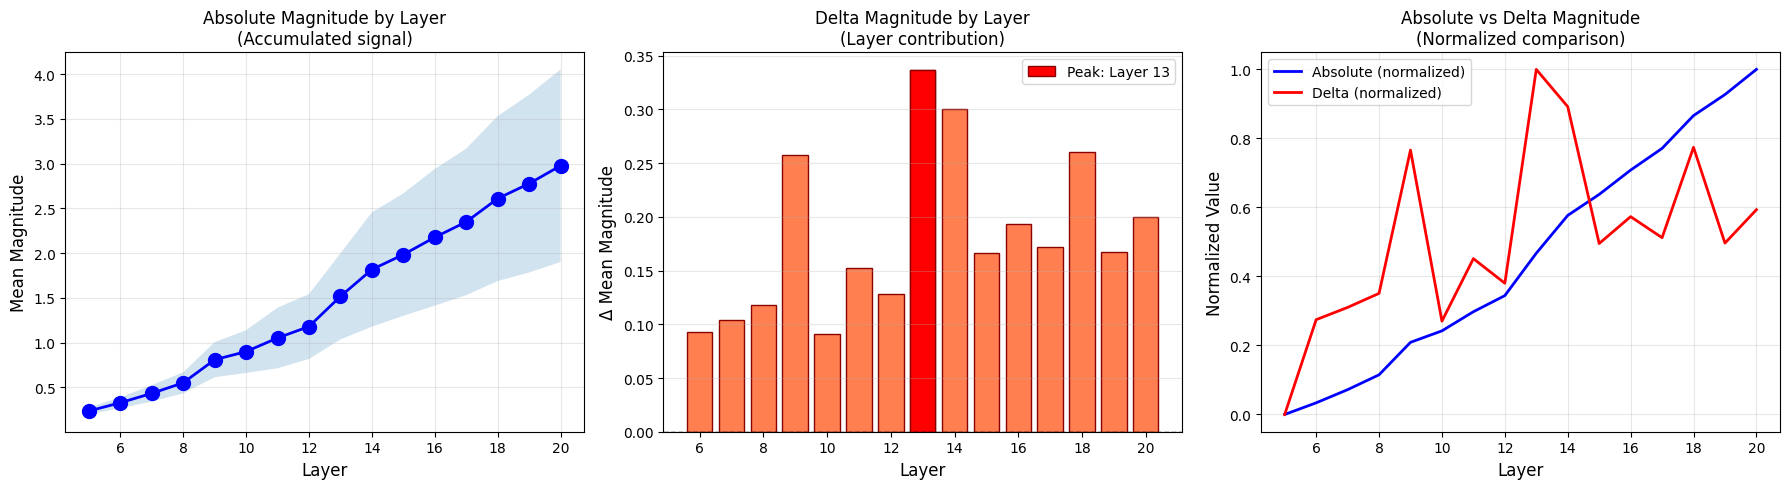


🎯 Peak delta layer (most demographic info added): Layer 13


In [7]:
# Visualize: Absolute Magnitude vs Delta Magnitude
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Absolute mean magnitude by layer
axes[0].plot(mag_df['layer'], mag_df['mean'], 'bo-', linewidth=2, markersize=10)
axes[0].fill_between(mag_df['layer'],
                      mag_df['mean'] - mag_df['std'],
                      mag_df['mean'] + mag_df['std'],
                      alpha=0.2)
axes[0].set_xlabel('Layer', fontsize=12)
axes[0].set_ylabel('Mean Magnitude', fontsize=12)
axes[0].set_title('Absolute Magnitude by Layer\n(Accumulated signal)', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Plot 2: Delta magnitude by layer
valid_delta = mag_df[mag_df['delta_mean'].notna()]
axes[1].bar(valid_delta['layer'], valid_delta['delta_mean'], color='coral', edgecolor='darkred')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1].set_xlabel('Layer', fontsize=12)
axes[1].set_ylabel('Δ Mean Magnitude', fontsize=12)
axes[1].set_title('Delta Magnitude by Layer\n(Layer contribution)', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')

# Highlight the peak delta layer
if len(avg_delta_per_layer) > 0:
    peak_layer = max(avg_delta_per_layer, key=avg_delta_per_layer.get)
    peak_idx = valid_delta[valid_delta['layer'] == peak_layer].index
    if len(peak_idx) > 0:
        axes[1].bar(peak_layer, valid_delta.loc[peak_idx[0], 'delta_mean'],
                    color='red', edgecolor='darkred', label=f'Peak: Layer {peak_layer}')
        axes[1].legend()

# Plot 3: Both metrics normalized for comparison
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
mag_normalized = scaler.fit_transform(mag_df[['mean']].values)
delta_normalized = mag_df['delta_mean'].fillna(0).values
delta_normalized = (delta_normalized - delta_normalized.min()) / (delta_normalized.max() - delta_normalized.min() + 1e-8)

axes[2].plot(mag_df['layer'], mag_normalized, 'b-', linewidth=2, label='Absolute (normalized)')
axes[2].plot(mag_df['layer'], delta_normalized, 'r-', linewidth=2, label='Delta (normalized)')
axes[2].set_xlabel('Layer', fontsize=12)
axes[2].set_ylabel('Normalized Value', fontsize=12)
axes[2].set_title('Absolute vs Delta Magnitude\n(Normalized comparison)', fontsize=12)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n🎯 Peak delta layer (most demographic info added): Layer {peak_layer}")

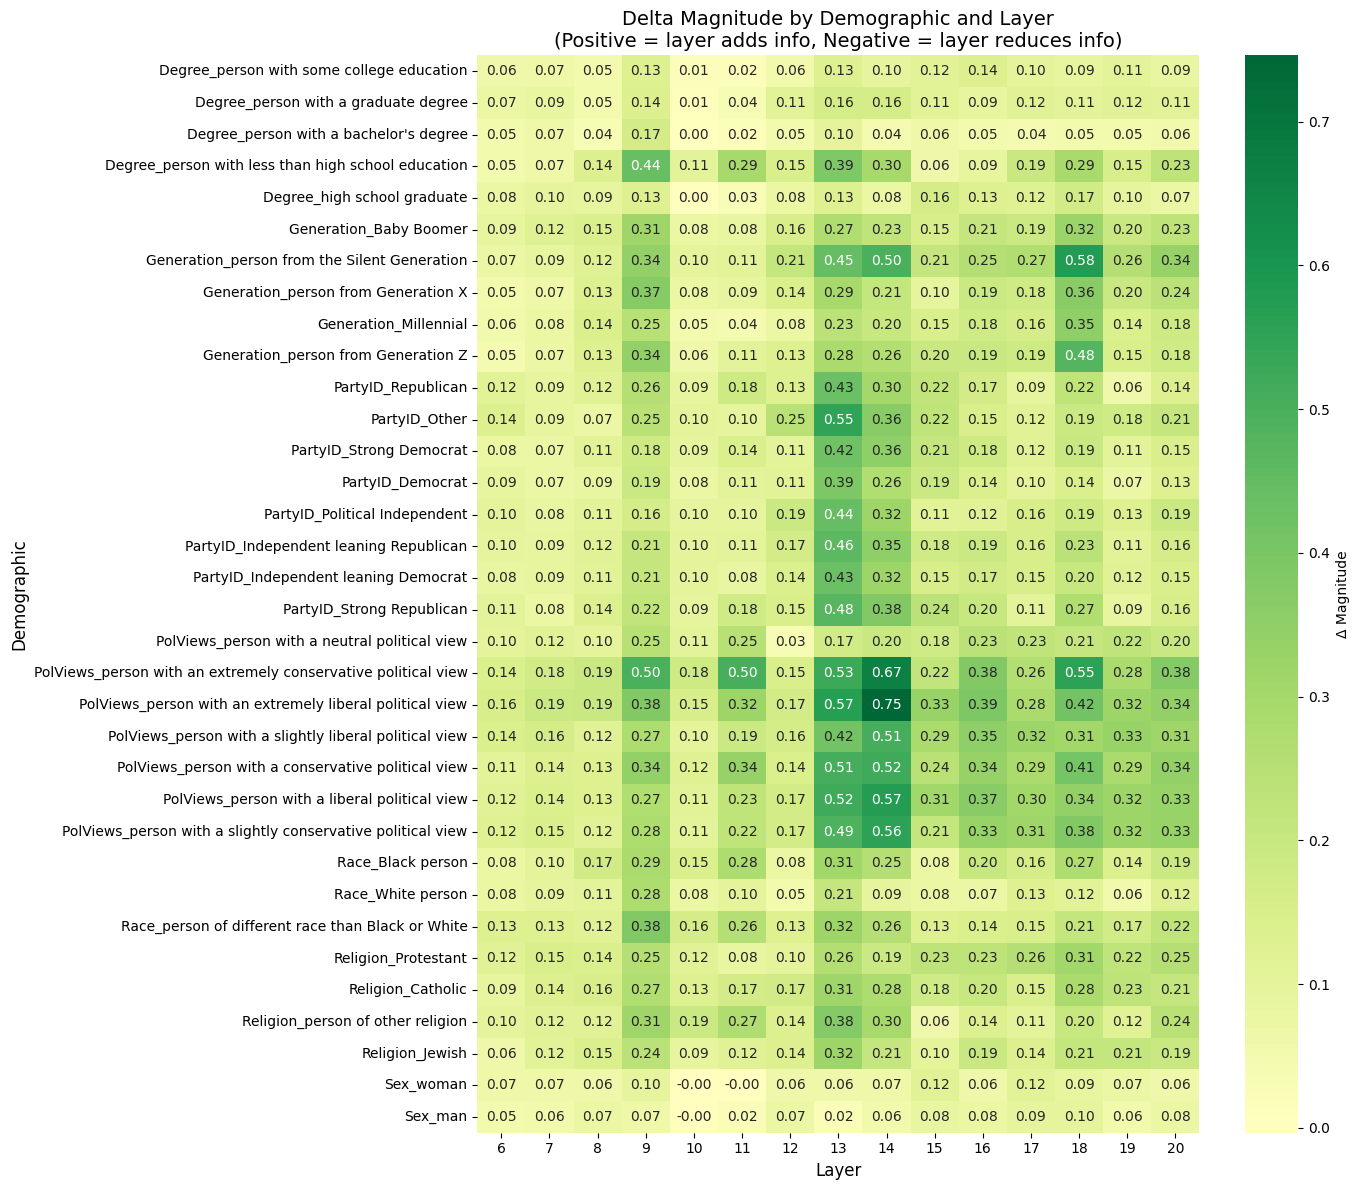


Demographics with highest delta variation across layers:
PolViews_person with an extremely conservative political view    0.029587
PolViews_person with an extremely liberal political view         0.026612
Generation_person from the Silent Generation                     0.024412
PolViews_person with a liberal political view                    0.019285
PolViews_person with a conservative political view               0.018457
PolViews_person with a slightly conservative political view      0.018149
PartyID_Other                                                    0.015477
Degree_person with less than high school education               0.014630
PolViews_person with a slightly liberal political view           0.013659
Generation_person from Generation Z                              0.013342
dtype: float64


In [8]:
# Heatmap: Delta magnitude by demographic and layer
delta_df = pd.DataFrame(delta_by_demo).T
delta_df = delta_df[layers_sorted[1:]]  # Exclude first layer (no delta)

# Sort by category for better visualization
delta_df['category'] = [label.split('_')[0] for label in delta_df.index]
delta_df = delta_df.sort_values('category')
delta_df = delta_df.drop('category', axis=1)

plt.figure(figsize=(14, 12))
sns.heatmap(
    delta_df.astype(float),
    cmap='RdYlGn',
    center=0,
    annot=True,
    fmt='.2f',
    xticklabels=True,
    yticklabels=True,
    cbar_kws={'label': 'Δ Magnitude'}
)
plt.xlabel('Layer', fontsize=12)
plt.ylabel('Demographic', fontsize=12)
plt.title('Delta Magnitude by Demographic and Layer\n(Positive = layer adds info, Negative = layer reduces info)', fontsize=14)
plt.tight_layout()
plt.show()

# Find which demographics have the most variation across layers
delta_var = delta_df.var(axis=1).sort_values(ascending=False)
print("\nDemographics with highest delta variation across layers:")
print(delta_var.head(10))

In [9]:
# Save the magnitude and delta analysis
mag_df.to_csv(os.path.join(BASE_DIR, "layer_magnitude_analysis.csv"), index=False)
delta_df.to_csv(os.path.join(BASE_DIR, "layer_delta_magnitude.csv"))

print("Saved magnitude analysis:")
print("  - layer_magnitude_analysis.csv")
print("  - layer_delta_magnitude.csv")

# Store peak delta layer for later comparison with steering effectiveness
PEAK_DELTA_LAYER = peak_layer
print(f"\nPeak delta layer to compare with steering effectiveness: {PEAK_DELTA_LAYER}")

Saved magnitude analysis:
  - layer_magnitude_analysis.csv
  - layer_delta_magnitude.csv

Peak delta layer to compare with steering effectiveness: 13


## 1. Build Baseline Similarity Matrix (Per Layer)

Compute pairwise cosine similarities between all demographic vectors for each layer.

In [10]:
def compute_similarity_matrix(vectors_dict):
    """
    Compute pairwise cosine similarity matrix for all demographic vectors.
    """
    labels = list(vectors_dict.keys())
    n = len(labels)
    sim_matrix = np.zeros((n, n))

    for i, label_a in enumerate(labels):
        vec_a = vectors_dict[label_a]['vector']
        for j, label_b in enumerate(labels):
            vec_b = vectors_dict[label_b]['vector']
            sim = F.cosine_similarity(vec_a.unsqueeze(0), vec_b.unsqueeze(0)).item()
            sim_matrix[i, j] = sim

    return pd.DataFrame(sim_matrix, index=labels, columns=labels)

# Compute baseline similarities for a reference layer (e.g., Layer 15)
REF_LAYER = 15
if REF_LAYER in all_layer_vectors:
    baseline_sim_df = compute_similarity_matrix(all_layer_vectors[REF_LAYER])
    print(f"Baseline similarity matrix shape: {baseline_sim_df.shape}")

Baseline similarity matrix shape: (34, 34)


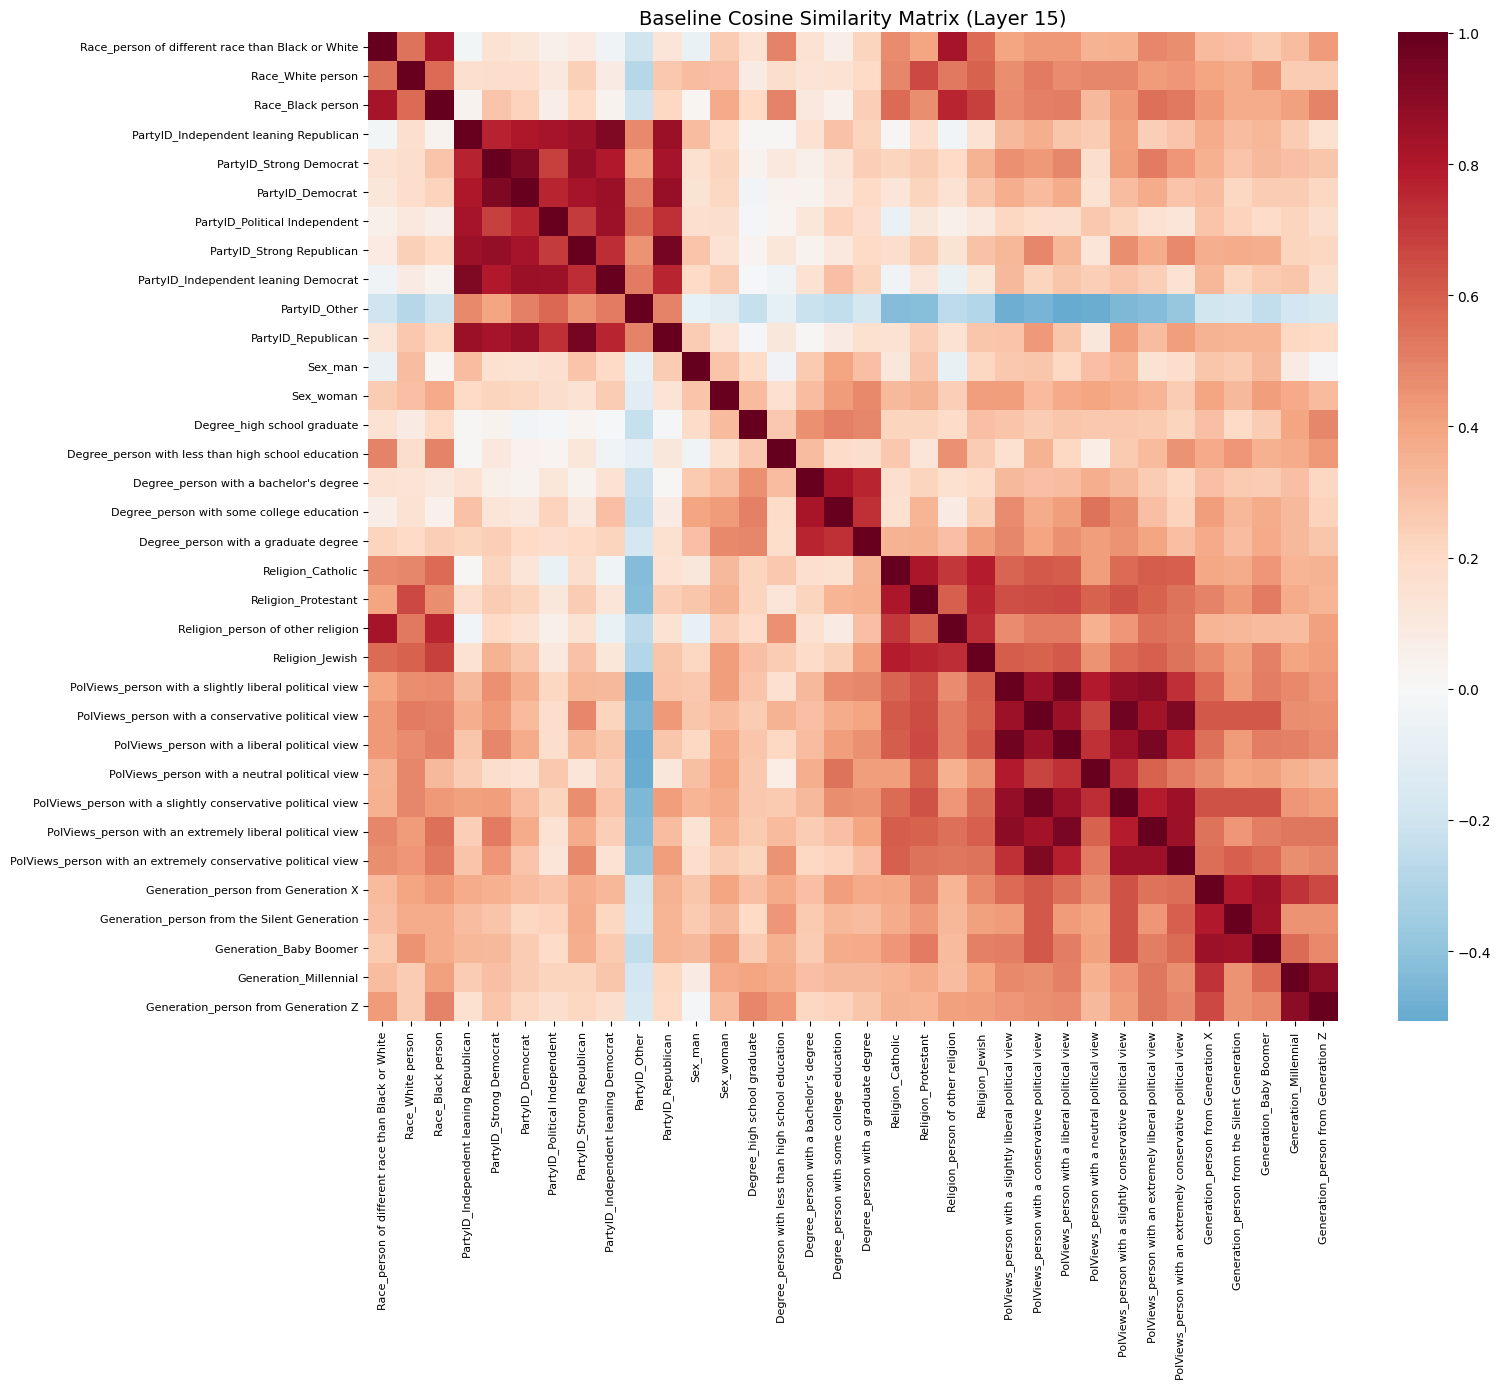

In [11]:
# Visualize baseline similarity matrix
plt.figure(figsize=(16, 14))
sns.heatmap(
    baseline_sim_df,
    cmap='RdBu_r',
    center=0,
    annot=False,
    xticklabels=True,
    yticklabels=True
)
plt.title(f"Baseline Cosine Similarity Matrix (Layer {REF_LAYER})", fontsize=14)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

## 2. Load Model for Steering Experiments

In [13]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_name = "meta-llama/Meta-Llama-3-8B-Instruct"

# Configure 4-bit quantization
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=quantization_config, # Use quantization_config instead of load_in_4bit
    device_map="auto",
    torch_dtype=torch.float16 # torch_dtype is still relevant for compute_dtype
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

print("Model loaded successfully.")

Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Model loaded successfully.


## 3. Define Steering Functions

In [14]:
def get_activations_with_steering(model, tokenizer, text, layer_idx, steering_vector=None, strength=0.0):
    """
    Get hidden state activations with optional steering vector injection.

    Args:
        model: The LLM model
        tokenizer: Tokenizer
        text: Input text
        layer_idx: Which layer to extract/inject
        steering_vector: Optional steering vector to inject (must be from SAME layer)
        strength: Injection strength multiplier

    Returns:
        Hidden state at the last token position
    """
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    captured_hidden = None

    def hook_fn(module, input, output):
        nonlocal captured_hidden

        if isinstance(output, tuple):
            h_states = output[0]
        else:
            h_states = output

        # Apply steering if provided
        if steering_vector is not None and strength != 0.0:
            steer = steering_vector.to(h_states.device).to(h_states.dtype)
            # Add steering vector to all token positions
            h_states = h_states + strength * steer.unsqueeze(0).unsqueeze(0)

        if h_states.dim() == 3:
            captured_hidden = h_states[0, -1, :].detach().cpu()
        elif h_states.dim() == 2:
            captured_hidden = h_states[-1, :].detach().cpu()

        # Return modified output if steering was applied
        if steering_vector is not None and strength != 0.0:
            if isinstance(output, tuple):
                return (h_states,) + output[1:]
            return h_states
        return output

    layer = model.model.layers[layer_idx]
    handle = layer.register_forward_hook(hook_fn)

    with torch.no_grad():
        model(**inputs)

    handle.remove()
    return captured_hidden

## 4. Measure How Steering Affects Other Demographics (Same Layer)

**Key:** For each layer, use vectors extracted at THAT layer for both steering and comparison.

In [15]:
def measure_steering_effect_same_layer(model, tokenizer, layer_vectors,
                                       steering_label, layer_idx, strength=2.0):
    """
    Measure how steering with one demographic affects similarities to all others.

    IMPORTANT: Uses vectors from the SAME layer for both steering and comparison.

    Args:
        layer_vectors: Dictionary of vectors extracted at layer_idx
        steering_label: The demographic to steer toward
        layer_idx: Layer to inject steering vector (same as extraction layer)
        strength: Steering strength

    Returns:
        DataFrame with baseline and steered similarities for each demographic
    """
    # Get the steering vector (extracted at this layer)
    steering_vec = layer_vectors[steering_label]['vector']

    # Test prompt (neutral)
    test_prompt = "[INST] You are a person living in the United States. What are your thoughts on current events? [/INST]"

    # Get baseline activation (no steering)
    baseline_act = get_activations_with_steering(
        model, tokenizer, test_prompt, layer_idx,
        steering_vector=None, strength=0.0
    )

    # Get steered activation
    steered_act = get_activations_with_steering(
        model, tokenizer, test_prompt, layer_idx,
        steering_vector=steering_vec, strength=strength
    )

    # Measure similarity to all demographic vectors (from same layer)
    results = []

    for label, data in layer_vectors.items():
        demo_vec = data['vector']

        # Baseline similarity
        baseline_sim = F.cosine_similarity(
            baseline_act.unsqueeze(0), demo_vec.unsqueeze(0)
        ).item()

        # Steered similarity
        steered_sim = F.cosine_similarity(
            steered_act.unsqueeze(0), demo_vec.unsqueeze(0)
        ).item()

        # Change
        delta = steered_sim - baseline_sim

        results.append({
            'demographic': label,
            'category': label.split('_')[0],
            'baseline_sim': baseline_sim,
            'steered_sim': steered_sim,
            'delta': delta,
            'layer': layer_idx
        })

    return pd.DataFrame(results)

In [16]:
# Run experiment: Steer toward "Strong Republican" at Layer 15
STEERING_DEMOGRAPHIC = "PartyID_Strong Republican"
TEST_LAYER = 15
STRENGTH = 2.0

print(f"Steering toward: {STEERING_DEMOGRAPHIC}")
print(f"Layer: {TEST_LAYER} (extract AND inject at same layer)")
print(f"Strength: {STRENGTH}")

republican_steering_results = measure_steering_effect_same_layer(
    model, tokenizer,
    all_layer_vectors[TEST_LAYER],
    steering_label=STEERING_DEMOGRAPHIC,
    layer_idx=TEST_LAYER,
    strength=STRENGTH
)

# Sort by delta (biggest changes first)
republican_steering_results = republican_steering_results.sort_values('delta', ascending=False)
republican_steering_results.head(10)

Steering toward: PartyID_Strong Republican
Layer: 15 (extract AND inject at same layer)
Strength: 2.0


,demographic,category,baseline_sim,steered_sim,delta,layer
7,PartyID_Strong Republican,PartyID,0.056610,0.305420,0.248810,15
10,PartyID_Republican,PartyID,0.059174,0.297363,0.238190,15
4,PartyID_Strong Democrat,PartyID,0.073608,0.290771,0.217163,15
3,PartyID_Independent leaning Republican,PartyID,0.002537,0.216797,0.214260,15
5,PartyID_Democrat,PartyID,0.065979,0.271484,0.205505,15
8,PartyID_Independent leaning Democrat,PartyID,0.010551,0.195190,0.184639,15
6,PartyID_Political Independent,PartyID,0.020630,0.195068,0.174438,15
23,PolViews_person with a conservative political ...,PolViews,-0.032593,0.090820,0.123413,15
28,PolViews_person with an extremely conservative...,PolViews,-0.026855,0.095215,0.122070,15
26,PolViews_person with a slightly conservative p...,PolViews,-0.046753,0.073425,0.120178,15


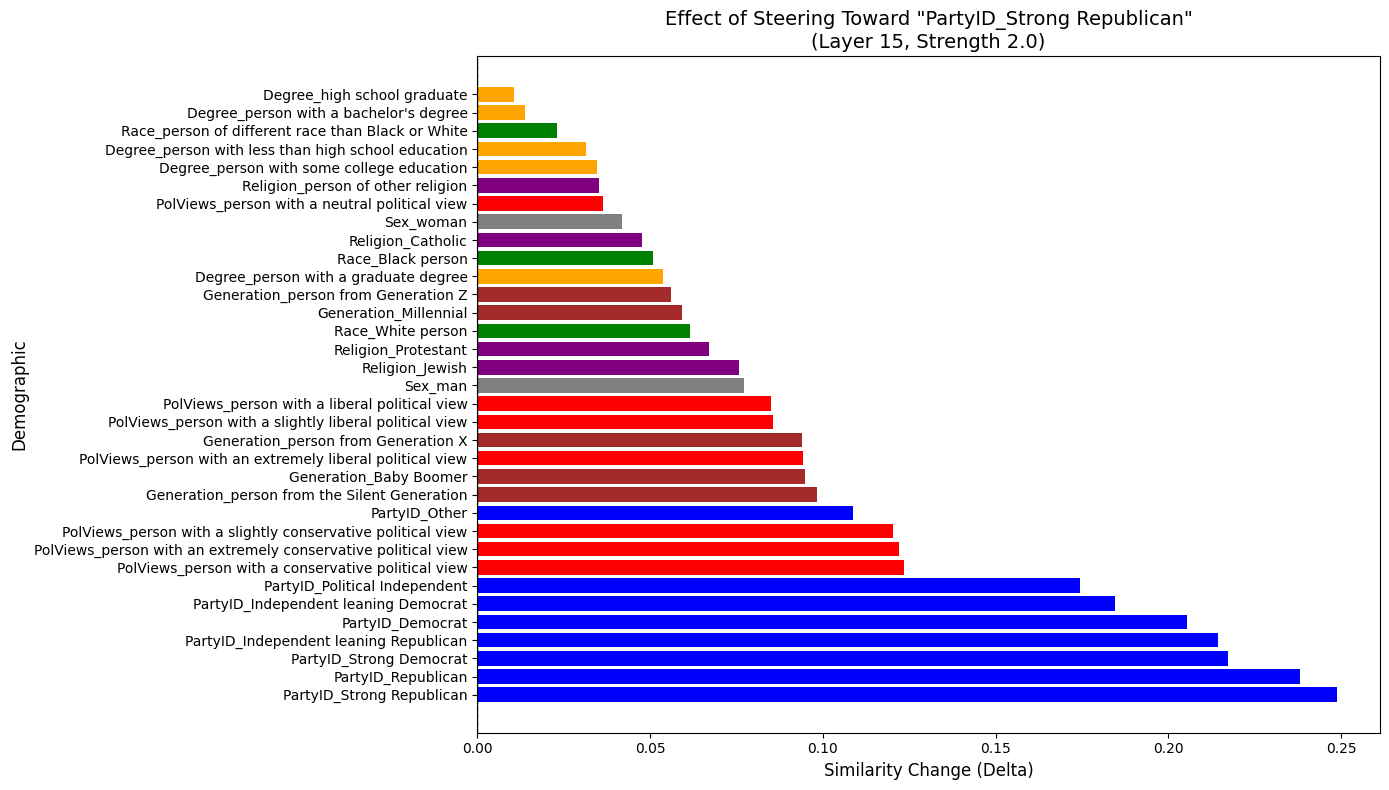

In [17]:
# Visualize: Which demographics move most when steering toward Republican?
plt.figure(figsize=(14, 8))

# Color by category
colors = republican_steering_results['category'].map({
    'PartyID': 'blue',
    'PolViews': 'red',
    'Race': 'green',
    'Religion': 'purple',
    'Degree': 'orange',
    'Generation': 'brown',
    'Sex': 'gray'
}).fillna('black')

plt.barh(
    republican_steering_results['demographic'],
    republican_steering_results['delta'],
    color=colors
)

plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Similarity Change (Delta)', fontsize=12)
plt.ylabel('Demographic', fontsize=12)
plt.title(f'Effect of Steering Toward "{STEERING_DEMOGRAPHIC}"\n(Layer {TEST_LAYER}, Strength {STRENGTH})', fontsize=14)
plt.tight_layout()
plt.show()

In [18]:
# Run experiment: Steer toward "Strong Republican" at Layer 13
STEERING_DEMOGRAPHIC = "PartyID_Strong Republican"
TEST_LAYER = 13
STRENGTH = 2.0

print(f"Steering toward: {STEERING_DEMOGRAPHIC}")
print(f"Layer: {TEST_LAYER} (extract AND inject at same layer)")
print(f"Strength: {STRENGTH}")

republican_steering_results = measure_steering_effect_same_layer(
    model, tokenizer,
    all_layer_vectors[TEST_LAYER],
    steering_label=STEERING_DEMOGRAPHIC,
    layer_idx=TEST_LAYER,
    strength=STRENGTH
)

# Sort by delta (biggest changes first)
republican_steering_results = republican_steering_results.sort_values('delta', ascending=False)
republican_steering_results.head(10)

Steering toward: PartyID_Strong Republican
Layer: 13 (extract AND inject at same layer)
Strength: 2.0


,demographic,category,baseline_sim,steered_sim,delta,layer
7,PartyID_Strong Republican,PartyID,0.014915,0.319824,0.304909,13
10,PartyID_Republican,PartyID,0.002542,0.292236,0.289694,13
4,PartyID_Strong Democrat,PartyID,0.037415,0.323486,0.286072,13
5,PartyID_Democrat,PartyID,0.020279,0.289551,0.269272,13
3,PartyID_Independent leaning Republican,PartyID,0.014725,0.280762,0.266037,13
8,PartyID_Independent leaning Democrat,PartyID,0.027466,0.270264,0.242798,13
6,PartyID_Political Independent,PartyID,0.026321,0.263184,0.236862,13
9,PartyID_Other,PartyID,0.061768,0.221924,0.160156,13
28,PolViews_person with an extremely conservative...,PolViews,-0.051270,0.078552,0.129822,13
23,PolViews_person with a conservative political ...,PolViews,-0.048706,0.080322,0.129028,13


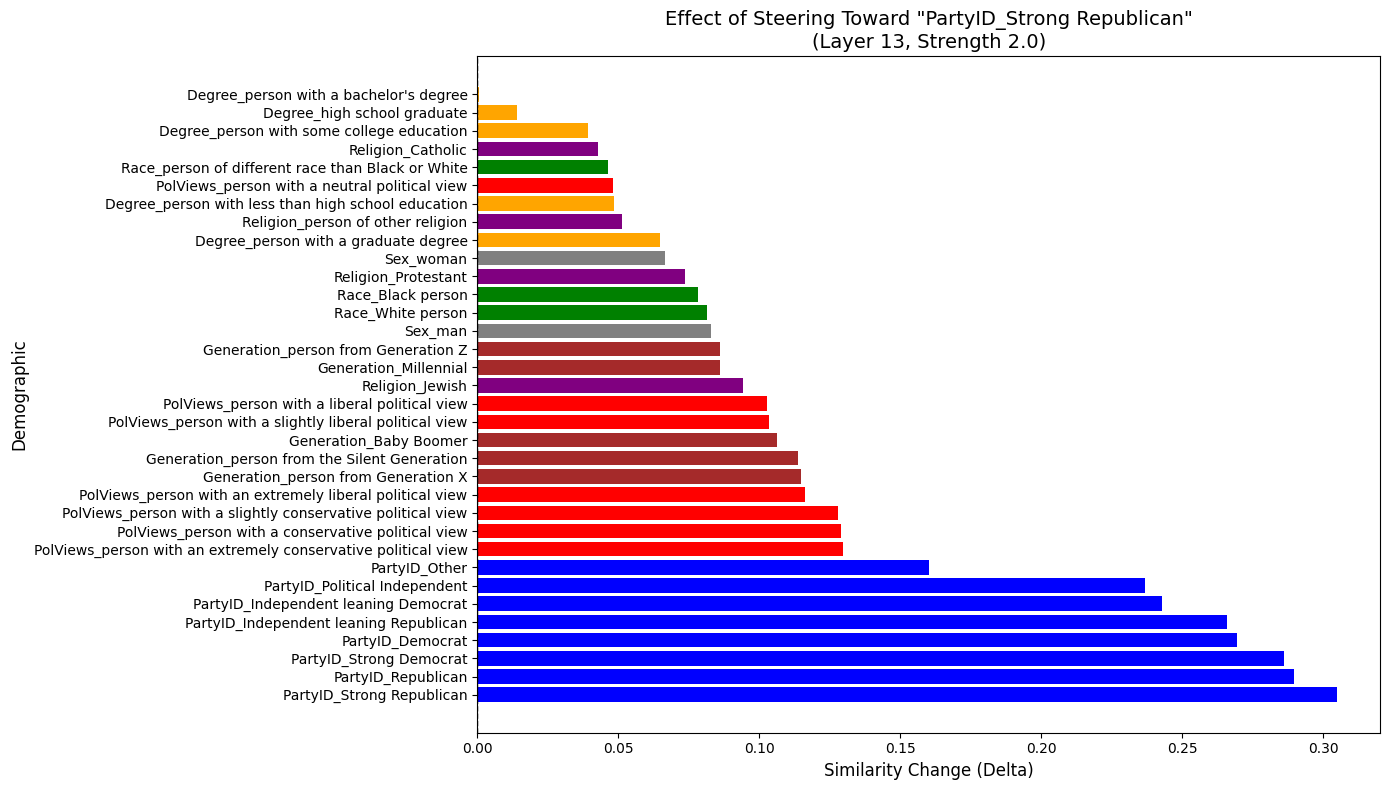

In [19]:
# Visualize: Which demographics move most when steering toward Republican?
plt.figure(figsize=(14, 8))

# Color by category
colors = republican_steering_results['category'].map({
    'PartyID': 'blue',
    'PolViews': 'red',
    'Race': 'green',
    'Religion': 'purple',
    'Degree': 'orange',
    'Generation': 'brown',
    'Sex': 'gray'
}).fillna('black')

plt.barh(
    republican_steering_results['demographic'],
    republican_steering_results['delta'],
    color=colors
)

plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Similarity Change (Delta)', fontsize=12)
plt.ylabel('Demographic', fontsize=12)
plt.title(f'Effect of Steering Toward "{STEERING_DEMOGRAPHIC}"\n(Layer {TEST_LAYER}, Strength {STRENGTH})', fontsize=14)
plt.tight_layout()
plt.show()

## 5. Compare Steering Effects Across Layers

For each layer, extract vectors at that layer AND steer at that same layer.

In [20]:
# Test steering effectiveness across layers (same layer for extract & inject)
STEERING_DEMO = "PartyID_Strong Republican"
TARGET_DEMO = "PolViews_person with a conservative political view"  # Should increase
STRENGTH = 2.0

layer_comparison_results = []

for layer in all_layer_vectors.keys():
    print(f"Testing Layer {layer} (extract & inject at same layer)...")

    results = measure_steering_effect_same_layer(
        model, tokenizer,
        all_layer_vectors[layer],
        steering_label=STEERING_DEMO,
        layer_idx=layer,
        strength=STRENGTH
    )

    # Get delta for target demographic
    target_row = results[results['demographic'] == TARGET_DEMO]
    if len(target_row) > 0:
        delta = target_row['delta'].values[0]
        layer_comparison_results.append({
            'layer': layer,
            'target_delta': delta,
            'avg_delta': results['delta'].abs().mean()
        })

layer_df = pd.DataFrame(layer_comparison_results)
print("\nLayer comparison complete!")
layer_df

Testing Layer 5 (extract & inject at same layer)...
Testing Layer 6 (extract & inject at same layer)...
Testing Layer 7 (extract & inject at same layer)...
Testing Layer 8 (extract & inject at same layer)...
Testing Layer 9 (extract & inject at same layer)...
Testing Layer 10 (extract & inject at same layer)...
Testing Layer 11 (extract & inject at same layer)...
Testing Layer 12 (extract & inject at same layer)...
Testing Layer 13 (extract & inject at same layer)...
Testing Layer 14 (extract & inject at same layer)...
Testing Layer 15 (extract & inject at same layer)...
Testing Layer 16 (extract & inject at same layer)...
Testing Layer 17 (extract & inject at same layer)...
Testing Layer 18 (extract & inject at same layer)...
Testing Layer 19 (extract & inject at same layer)...
Testing Layer 20 (extract & inject at same layer)...

Layer comparison complete!


,layer,target_delta,avg_delta
0,5,0.117584,0.151451
1,6,0.095947,0.150690
2,7,0.124949,0.167834
3,8,0.173279,0.167829
4,9,0.170593,0.152985
5,10,0.166351,0.153249
6,11,0.200768,0.164114
7,12,0.160217,0.139531
8,13,0.129028,0.120732
9,14,0.127319,0.108166


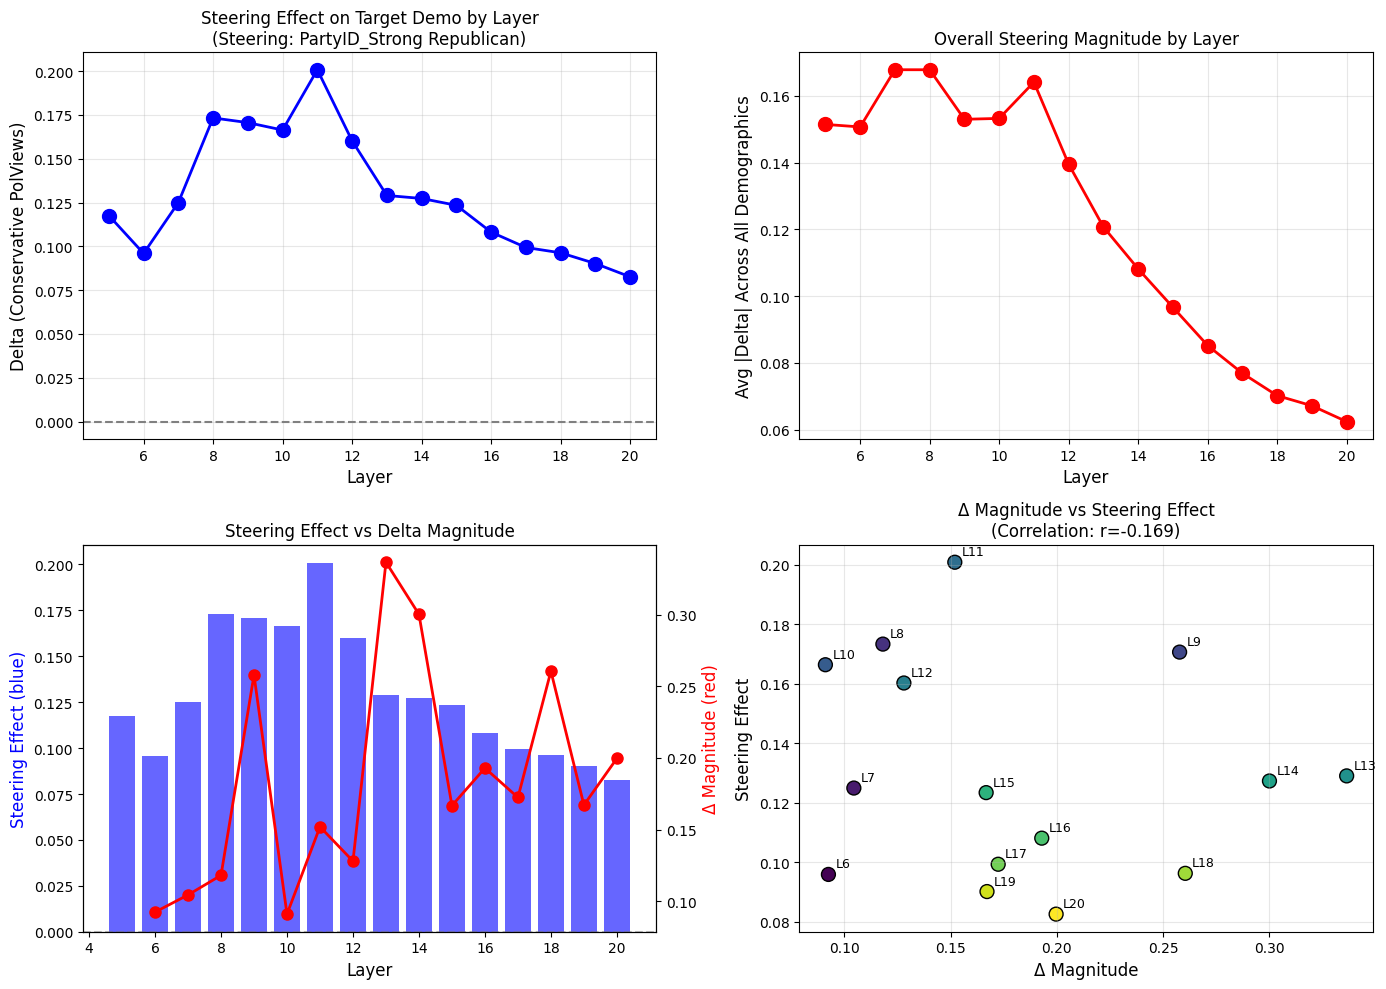


=== OPTIMAL LAYER ANALYSIS ===
Best layer by steering effectiveness: Layer 11
Best layer by delta magnitude: Layer 13
Note: Criteria disagree - investigate both layers 11 and 13


In [21]:
# Visualize layer comparison with delta magnitude correlation
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Target demographic delta by layer
axes[0, 0].plot(layer_df['layer'], layer_df['target_delta'], 'bo-', linewidth=2, markersize=10)
axes[0, 0].axhline(y=0, color='gray', linestyle='--')
axes[0, 0].set_xlabel('Layer', fontsize=12)
axes[0, 0].set_ylabel('Delta (Conservative PolViews)', fontsize=12)
axes[0, 0].set_title(f'Steering Effect on Target Demo by Layer\n(Steering: {STEERING_DEMO})', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Average absolute delta by layer
axes[0, 1].plot(layer_df['layer'], layer_df['avg_delta'], 'ro-', linewidth=2, markersize=10)
axes[0, 1].set_xlabel('Layer', fontsize=12)
axes[0, 1].set_ylabel('Avg |Delta| Across All Demographics', fontsize=12)
axes[0, 1].set_title('Overall Steering Magnitude by Layer', fontsize=12)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Overlay magnitude delta with steering effectiveness
# Merge delta magnitude data with layer comparison
layer_df_merged = layer_df.copy()
layer_df_merged['delta_magnitude'] = layer_df_merged['layer'].map(
    lambda x: avg_delta_per_layer.get(x, np.nan)
)

ax3 = axes[1, 0]
ax3_twin = ax3.twinx()
ax3.bar(layer_df_merged['layer'], layer_df_merged['target_delta'],
        color='blue', alpha=0.6, label='Steering Effect')
ax3_twin.plot(layer_df_merged['layer'], layer_df_merged['delta_magnitude'],
              'r-o', linewidth=2, markersize=8, label='Δ Magnitude')
ax3.set_xlabel('Layer', fontsize=12)
ax3.set_ylabel('Steering Effect (blue)', fontsize=12, color='blue')
ax3_twin.set_ylabel('Δ Magnitude (red)', fontsize=12, color='red')
ax3.set_title('Steering Effect vs Delta Magnitude', fontsize=12)
ax3.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

# Plot 4: Scatter plot - Delta magnitude vs Steering effectiveness
valid_data = layer_df_merged.dropna(subset=['delta_magnitude', 'target_delta'])
axes[1, 1].scatter(valid_data['delta_magnitude'], valid_data['target_delta'],
                   s=100, c=valid_data['layer'], cmap='viridis', edgecolors='black')

# Add layer labels
for _, row in valid_data.iterrows():
    axes[1, 1].annotate(f"L{int(row['layer'])}",
                        (row['delta_magnitude'], row['target_delta']),
                        xytext=(5, 5), textcoords='offset points', fontsize=9)

# Compute correlation
if len(valid_data) > 2:
    corr = valid_data['delta_magnitude'].corr(valid_data['target_delta'])
    axes[1, 1].set_title(f'Δ Magnitude vs Steering Effect\n(Correlation: r={corr:.3f})', fontsize=12)
else:
    axes[1, 1].set_title('Δ Magnitude vs Steering Effect', fontsize=12)

axes[1, 1].set_xlabel('Δ Magnitude', fontsize=12)
axes[1, 1].set_ylabel('Steering Effect', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find best layers by different criteria
best_layer_steering = layer_df.loc[layer_df['target_delta'].idxmax(), 'layer']
best_layer_delta = max(avg_delta_per_layer, key=avg_delta_per_layer.get) if avg_delta_per_layer else None

print(f"\n=== OPTIMAL LAYER ANALYSIS ===")
print(f"Best layer by steering effectiveness: Layer {best_layer_steering}")
print(f"Best layer by delta magnitude: Layer {best_layer_delta}")
if best_layer_steering == best_layer_delta:
    print("✓ Both criteria agree!")
else:
    print(f"Note: Criteria disagree - investigate both layers {best_layer_steering} and {best_layer_delta}")

## 6. Full Steering Effect Matrix (Multiple Steering Directions)

Test multiple steering demographics at the optimal layer.

In [22]:
# Use best layer (or a specific layer)
ANALYSIS_LAYER = best_layer if 'best_layer' in dir() else 15
print(f"Running full analysis at Layer {ANALYSIS_LAYER}")

# List of demographics to test as steering vectors
steering_demographics = [
    "PartyID_Strong Republican",
    "PartyID_Strong Democrat",
    "Race_Black person",
    "Race_White person",
    "PolViews_person with a liberal political view",
    "PolViews_person with a conservative political view",
    "Generation_Millennial",
    "Generation_Baby Boomer"
]

# Collect results for all steering directions
all_steering_results = {}

for steer_demo in steering_demographics:
    if steer_demo in all_layer_vectors[ANALYSIS_LAYER]:
        print(f"Testing steering: {steer_demo}...")
        results = measure_steering_effect_same_layer(
            model, tokenizer,
            all_layer_vectors[ANALYSIS_LAYER],
            steering_label=steer_demo,
            layer_idx=ANALYSIS_LAYER,
            strength=STRENGTH
        )
        all_steering_results[steer_demo] = results
    else:
        print(f"WARNING: {steer_demo} not found in layer {ANALYSIS_LAYER} vectors")

print("\nDone!")

Running full analysis at Layer 15
Testing steering: PartyID_Strong Republican...
Testing steering: PartyID_Strong Democrat...
Testing steering: Race_Black person...
Testing steering: Race_White person...
Testing steering: PolViews_person with a liberal political view...
Testing steering: PolViews_person with a conservative political view...
Testing steering: Generation_Millennial...
Testing steering: Generation_Baby Boomer...

Done!


In [23]:
# Build a "Steering Effect Matrix"
# Rows: Steering demographic
# Columns: Affected demographic
# Values: Delta (similarity change)

all_demos = list(all_layer_vectors[ANALYSIS_LAYER].keys())
effect_matrix = pd.DataFrame(index=list(all_steering_results.keys()), columns=all_demos)

for steer_demo, results_df in all_steering_results.items():
    for _, row in results_df.iterrows():
        effect_matrix.loc[steer_demo, row['demographic']] = row['delta']

effect_matrix = effect_matrix.astype(float)
print(f"Effect matrix shape: {effect_matrix.shape}")

Effect matrix shape: (8, 34)


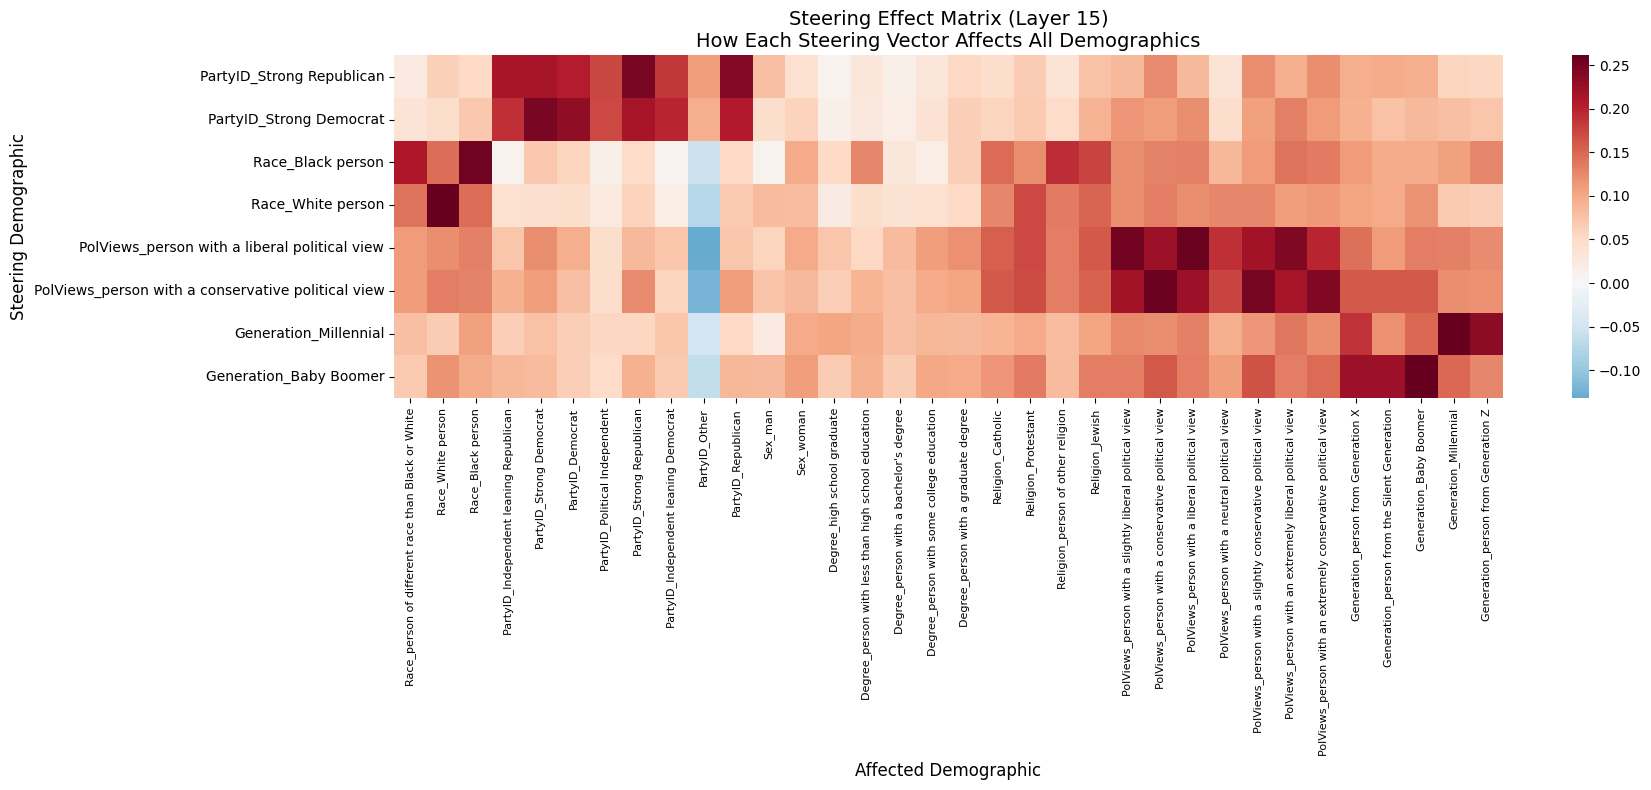

In [24]:
# Visualize the Steering Effect Matrix
plt.figure(figsize=(18, 8))
sns.heatmap(
    effect_matrix,
    cmap='RdBu_r',
    center=0,
    annot=False,
    xticklabels=True,
    yticklabels=True
)
plt.title(f"Steering Effect Matrix (Layer {ANALYSIS_LAYER})\nHow Each Steering Vector Affects All Demographics", fontsize=14)
plt.xlabel("Affected Demographic", fontsize=12)
plt.ylabel("Steering Demographic", fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

## 7. Identify Entangled Demographics

Find pairs of demographics that consistently move together when steering.

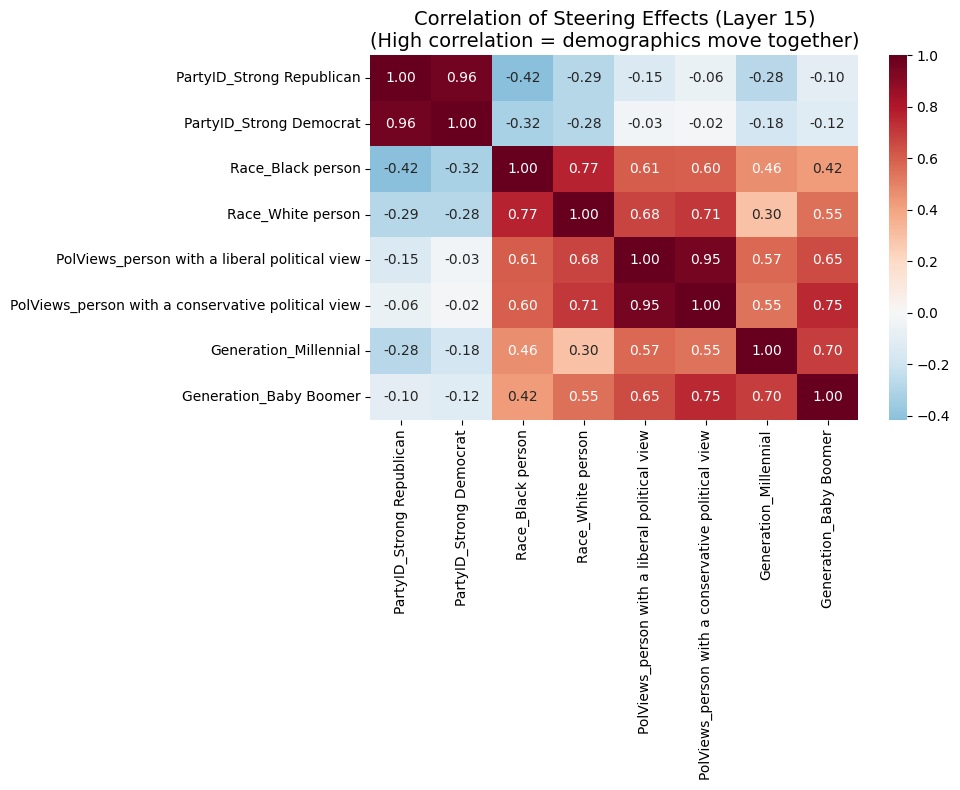

In [25]:
# Compute correlation of steering effects across demographics
# If two demographics always move together, they are "entangled"

effect_correlation = effect_matrix.T.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    effect_correlation,
    cmap='RdBu_r',
    center=0,
    annot=True,
    fmt='.2f',
    xticklabels=True,
    yticklabels=True
)
plt.title(f"Correlation of Steering Effects (Layer {ANALYSIS_LAYER})\n(High correlation = demographics move together)", fontsize=14)
plt.tight_layout()
plt.show()

In [26]:
# Find most entangled pairs (high positive correlation)
# and most opposing pairs (high negative correlation)

def get_top_pairs(corr_matrix, n=10):
    pairs = []
    labels = corr_matrix.index.tolist()

    for i, label_a in enumerate(labels):
        for j, label_b in enumerate(labels):
            if i < j:  # Avoid duplicates and self-pairs
                corr_val = corr_matrix.loc[label_a, label_b]
                pairs.append((label_a, label_b, corr_val))

    pairs_df = pd.DataFrame(pairs, columns=['Demo_A', 'Demo_B', 'Correlation'])
    return pairs_df.sort_values('Correlation', ascending=False)

steering_pairs = get_top_pairs(effect_correlation)

print("=== MOST ENTANGLED (Move Together) ===")
print(steering_pairs.head(5))

print("\n=== MOST OPPOSING (Move Opposite) ===")
print(steering_pairs.tail(5))

=== MOST ENTANGLED (Move Together) ===
                                               Demo_A  \
0                           PartyID_Strong Republican   
22      PolViews_person with a liberal political view   
13                                  Race_Black person   
26  PolViews_person with a conservative political ...   
19                                  Race_White person   

                                               Demo_B  Correlation  
0                             PartyID_Strong Democrat     0.957637  
22  PolViews_person with a conservative political ...     0.952637  
13                                  Race_White person     0.766102  
26                             Generation_Baby Boomer     0.747500  
19  PolViews_person with a conservative political ...     0.705177  

=== MOST OPPOSING (Move Opposite) ===
                      Demo_A                 Demo_B  Correlation
5  PartyID_Strong Republican  Generation_Millennial    -0.276259
8    PartyID_Strong Democrat      R

## 8. Save Results

In [27]:
# Save the steering effect matrix
effect_matrix.to_csv(os.path.join(BASE_DIR, f"steering_effect_matrix_layer{ANALYSIS_LAYER}.csv"))

# Save the layer comparison results (with delta magnitude)
layer_df_merged.to_csv(os.path.join(BASE_DIR, "layer_comparison_results.csv"), index=False)

# Save entanglement analysis
steering_pairs.to_csv(os.path.join(BASE_DIR, f"demographic_entanglement_layer{ANALYSIS_LAYER}.csv"), index=False)

print("Results saved!")
print(f"  - steering_effect_matrix_layer{ANALYSIS_LAYER}.csv")
print(f"  - layer_comparison_results.csv (includes delta magnitude)")
print(f"  - demographic_entanglement_layer{ANALYSIS_LAYER}.csv")
print(f"  - layer_magnitude_analysis.csv (from Section 0)")
print(f"  - layer_delta_magnitude.csv (from Section 0)")

Results saved!
  - steering_effect_matrix_layer15.csv
  - layer_comparison_results.csv (includes delta magnitude)
  - demographic_entanglement_layer15.csv
  - layer_magnitude_analysis.csv (from Section 0)
  - layer_delta_magnitude.csv (from Section 0)


## Summary

This notebook investigated demographic vector correlations using the **same-layer** design:

**Design Principle:** For each layer L:
- Load vectors extracted at layer L
- Inject steering at layer L
- Measure effects using vectors from layer L

**Key Analyses:**

0. **Magnitude vs Delta Analysis** (NEW)
   - Absolute magnitude increases across layers (residual accumulation)
   - Delta magnitude (Δ) shows layer-specific contribution
   - Peak Δ layer = where model adds most demographic info
   - Correlation between Δ and steering effectiveness

1. **Baseline similarities** between all demographic vectors
2. **Layer comparison** - which layer produces strongest/cleanest steering?
3. **Steering effects** - how injecting one demographic affects all others
4. **Entanglement patterns** - which demographics move together under steering

**Output Files:**
- `layer_magnitude_analysis.csv` - Absolute magnitude by layer
- `layer_delta_magnitude.csv` - Delta magnitude by demographic and layer
- `layer_comparison_results.csv` - Steering effectiveness with delta correlation
- `steering_effect_matrix_layer{L}.csv` - Full steering effect matrix
- `demographic_entanglement_layer{L}.csv` - Entanglement analysis